In [1]:
import os
from random import sample
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#import tensorflow as tf

In [2]:
#Load 1 test image, load 1 mask (NN softmax output)

#test_path = "../../../project/test_images/test_images"
#mask_path = "../../../project/masks/sresnet/marco_best"
#test_list = os.listdir(test_path)
#test_list.sort()
#mask_list = os.listdir(mask_path)
#mask_list.sort()
#image_name = test_list[0]
#mask_name = mask_list[0]
#print(test_list)

#image = np.array(Image.open(os.path.join(test_path, image_name)))
#mask = np.array(Image.open(os.path.join(mask_path, mask_name)))

img = np.array(Image.open("../../../project/test_images/test_images/test_10.png"))
mask = np.array(Image.open( "../../../project/masks/sresnet/marco_best/test_10.png" ))


(608, 608, 3)


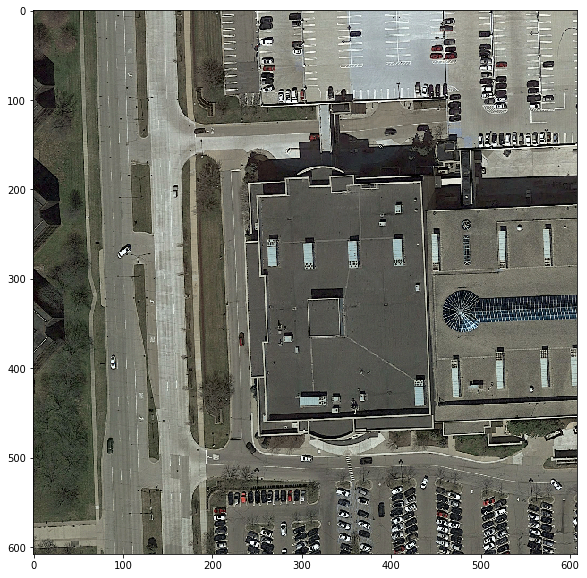

In [3]:
plt.figure(figsize=(10, 10))

IMAGE_SHAPE = np.shape(img)
print(IMAGE_SHAPE)

plt.imshow(img)

(608, 608)


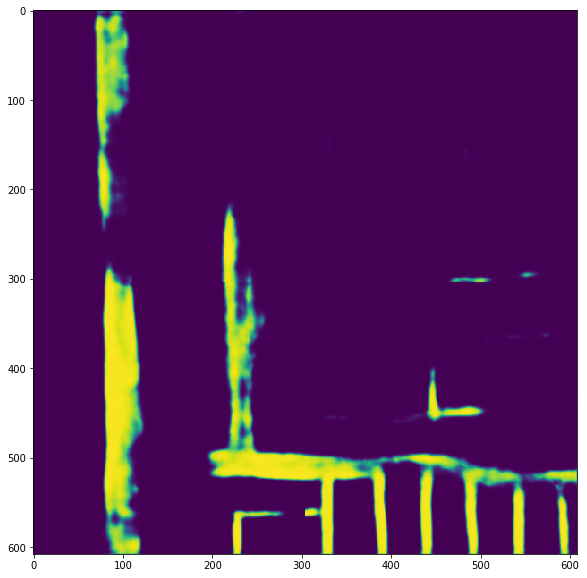

In [4]:
plt.figure(figsize=(10, 10))

print(np.shape(mask))
#print(mask[0])

plt.imshow(mask)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

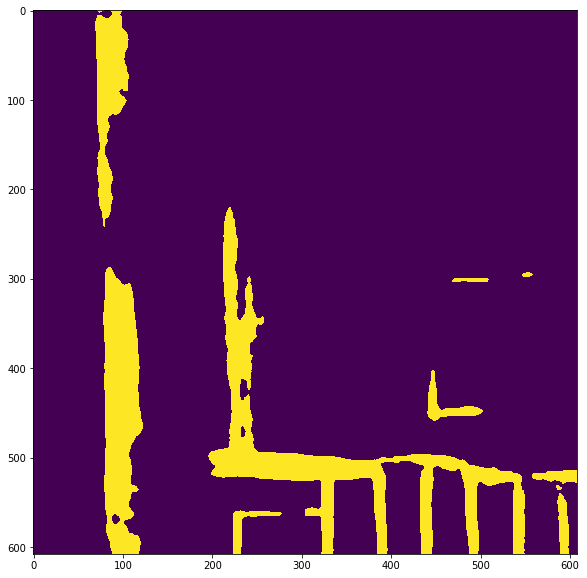

In [5]:
#Create probability map & binary map from Mask

MASK_2_BINARY_THRESHOLD = 0.25

prob_map = mask/255.0

binary_map = (prob_map > MASK_2_BINARY_THRESHOLD).astype('uint8')

print(binary_map[0])

plt.figure(figsize=(10, 10))
plt.imshow(binary_map)


(608, 608, 3)


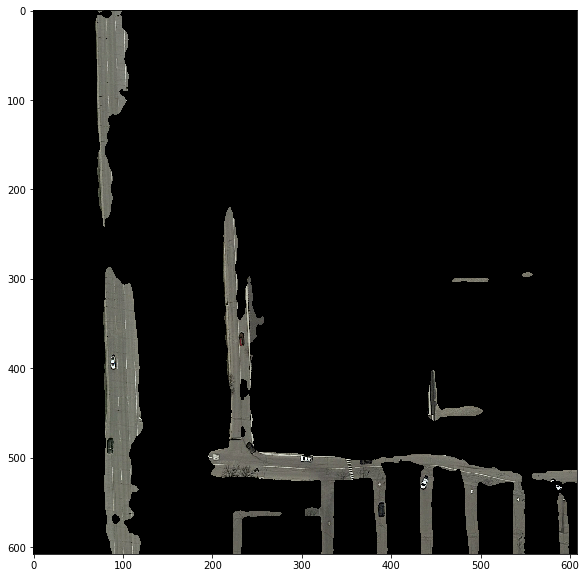

In [6]:
#Create version of the original image filter through the binary mask generated just now
#Cartesian product

binary_map_3c = np.zeros((binary_map.shape[0],binary_map.shape[1],3))
for i in range(3):
    binary_map_3c[:,:,i] = binary_map

print(np.shape(binary_map_3c))

plt.figure(figsize=(10, 10))
img_masked = binary_map_3c * img
img_masked = img_masked.astype('uint8')
plt.imshow(img_masked)


In [8]:
n_data_train = np.sum(binary_map.flatten())
n_data_pred = img.shape[0]*img.shape[1]
n_feats = 6
print(n_data_train)
print(n_data_pred)
print(n_feats)

#Quick Check
print(n_data_train/len(binary_map.flatten()))

37403
369664
6
0.10118107254155125


In [ ]:
#Generate a HSV version of mask-filtered original image
#Transform image to 5d feature space (HSV,XY)

#hsv_img_masked = cv2.cvtColor(img_masked, cv2.COLOR_RGB2HSV)
#h, s, v = cv2.split(hsv_img_masked)


In [9]:
#Transform original image to 5d feature space (HSV,XY)

hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)

print(np.shape(h))


(608, 608)


In [10]:
#Setting hsv_scale_factor = 0.0
#and
#n_clusters = 50
#would cause KMeans to create nicely shaped clusters with relatively limited distortion
#HYC 16/06 opinion this creates the best results

#Check optimal n_clusters using following cell
#Consider training&inference speed vs accuracy tradeoff

#columns=['x','y','h','s','v']

feats_train_xy = np.zeros((n_data_train,2))
feats_pred_xy = np.zeros((n_data_pred,2))
feats_train_hsv = np.zeros((n_data_train,3))
feats_pred_hsv = np.zeros((n_data_pred,3))

row_idx_train = 0
row_idx_pred = 0
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        feats_pred_xy[row_idx_pred][0] = x
        feats_pred_xy[row_idx_pred][1] = y
        row_idx_pred+=1
        if binary_map[y][x] == 1:
            feats_train_xy[row_idx_train][0] = x
            feats_train_xy[row_idx_train][1] = y
            
            feats_train_hsv[row_idx_train][0] = h[y][x]
            feats_train_hsv[row_idx_train][1] = s[y][x]
            feats_train_hsv[row_idx_train][2] = v[y][x]
            
            row_idx_train+=1
            
feats_pred_hsv[:,0] = h.flatten()
feats_pred_hsv[:,1] = s.flatten()
feats_pred_hsv[:,2] = v.flatten()

feats_train_xy = feats_train_xy.astype(np.float)
feats_pred_xy = feats_pred_xy.astype(np.float)
feats_train_hsv = feats_train_hsv.astype(np.float)
feats_pred_hsv = feats_pred_hsv.astype(np.float)


In [11]:
print(np.shape(feats_train_xy))
print(np.shape(feats_pred_xy))
print(np.shape(feats_pred_hsv))

print(feats_pred_hsv[:3])

(37403, 2)
(369664, 2)
(369664, 3)
[[20. 48. 64.]
 [13. 64. 48.]
 [15. 44. 92.]]


In [12]:
feats_train_scaled = np.zeros((n_data_train,n_feats))
feats_pred_scaled = np.zeros((n_data_pred,n_feats))


In [13]:
#Normalize, and store means & vars

scaler_xy = StandardScaler()
scaler_xy.fit(feats_train_xy)

feats_train_xy_scaled = scaler_xy.transform(feats_train_xy)
feats_train_scaled[:,0] = feats_train_xy_scaled[:,0]
feats_train_scaled[:,1] = feats_train_xy_scaled[:,1]

feats_pred_xy_scaled = scaler_xy.transform(feats_pred_xy)
feats_pred_scaled[:,0] = feats_pred_xy_scaled[:,0]
feats_pred_scaled[:,1] = feats_pred_xy_scaled[:,1]


In [ ]:
print(np.shape(feats_train_scaled))
print(np.shape(feats_pred_scaled))

print(scaler_xy.mean_[0])
print(np.sqrt(scaler_xy.var_[0]))

#feats_train_xy_scaled = np.zeros((n_data_train,2))

print(feats_train_scaled[0])



In [14]:

scaler_hsv = StandardScaler()
scaler_hsv.fit(feats_train_hsv)

#feats_train_hsv: trickly set to zeros.

feats_pred_hsv_scaled = scaler_hsv.transform(feats_pred_hsv)
feats_pred_scaled[:,2] = feats_pred_hsv_scaled[:,0]
feats_pred_scaled[:,3] = feats_pred_hsv_scaled[:,1]
feats_pred_scaled[:,4] = feats_pred_hsv_scaled[:,2]


In [ ]:
print(np.shape(feats_pred_scaled))

In [15]:
#Actual KMeans training
#KMeans parameters not really tampered with so far

km = KMeans(
    n_clusters=50, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(feats_train_scaled)

print(np.shape(y_km))
#print(feats_img_masked_normed[y_km==0,-2])


(37403,)


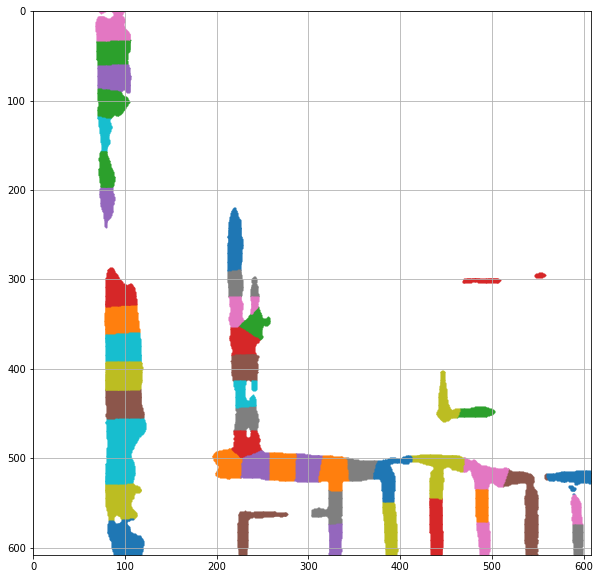

In [16]:
#Check appearance of all clusters
N_clusters = 50

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
for cluster_idx in range(N_clusters):
    ax1.scatter(
        feats_train_xy[y_km == cluster_idx, 0], feats_train_xy[y_km == cluster_idx, 1],
        s=1.0, 
        #edgecolor='black',
        label='cluster %d'%cluster_idx )

#ax1.legend(scatterpoints=1)
ax1.invert_yaxis()
ax1.set_ylim(bottom=608,top=0)
ax1.set_xlim(left=0,right=608)
ax1.grid()

In [17]:
METRIC_CHOICE = 3
n_near = 50
n_combs = int( (n_near-1)*n_near/2 )
n_align = 10

print(np.shape(km.cluster_centers_))
#print(km.cluster_centers_)
road_metric = np.zeros(n_data_pred)
road_metric2 = np.zeros(n_data_pred)
road_metric4 = np.zeros(n_data_pred)
road_metric5 = np.zeros(n_data_pred)
road_metric8 = np.zeros(n_data_pred)

cluster_cents = km.cluster_centers_[:,:2]
print(np.shape(cluster_cents))
#print(cluster_cents)

row_idx = 0
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        v_c = cluster_cents-feats_pred_scaled[row_idx][:2]
        
        m_c_sqed = (v_c[:,0])**2
        m_c_sqed += (v_c[:,1])**2

        idxs_near = np.argsort(m_c_sqed)[:n_near]
        
        v_c_near = v_c[idxs_near]
        
        prox_mat = np.outer(v_c_near[:,0],v_c_near[:,0])
        prox_mat += np.outer(v_c_near[:,1],v_c_near[:,1])
        prox_mat = np.abs(prox_mat)
        
        m_c_near = np.sqrt(np.diag(prox_mat))
        prox_mat_tmp = prox_mat/m_c_near
        prox_mat = (prox_mat_tmp.transpose())/m_c_near
        
        """
        ### metric 1
        pixel_metric = np.sum(np.triu(prox_mat,k=1))/n_combs 
            #avg of cosines considering n_near nearest clusters
        road_metric[row_idx] = pixel_metric
        
        ### metric 2
        prox_mat_col_avg = np.mean(prox_mat,axis=0)
        idxs_align = ((np.argsort(prox_mat_col_avg))[::-1])[:n_align]
        pixel_metric2 = np.mean(prox_mat_col_avg[idxs_align])
            #"avg of avg of" cosines considering n_align most well aligned clusters
        road_metric2[row_idx] = pixel_metric2
        
        
        ### metric 3
        prox_mat_align_col_avg = np.mean(np.abs(prox_mat),axis=0)
        idxs_align = ((np.argsort(prox_mat_col_avg))[::-1])[:n_align]
        pixel_metric2 = np.mean(prox_mat_col_avg[idxs_align])
            #"avg of avg of" cosines considering n_align most well aligned clusters
            #but with intermediate alignment filter
        road_metric2[row_idx] = pixel_metric2   
        
        
        ### metric 4
        pixel_metric4 = (np.count_nonzero(prox_mat>0.995))-n_near
        road_metric4[row_idx] = pixel_metric4

        ### metric 5
        #distance penalty
        
        decay = 100/(np.sqrt( np.sqrt(scaler_xy.var_[0]*scaler_xy.var_[1]) ))
        prox_mat_tmp = prox_mat*np.exp(-m_c_near/(2*decay))
        prox_mat_5 = (prox_mat_tmp.transpose())*np.exp(-m_c_near/(2*decay))
        
        pixel_metric5 = np.sum(np.triu(prox_mat_5,k=1))/n_combs 
            #avg of cosines considering n_near nearest clusters
        road_metric5[row_idx] = pixel_metric5
        

        ### metric 6
        #how well aligned are the most well aligned amongst themselves?
        prox_mat_col_avg = np.mean(prox_mat,axis=0)
        idxs_align = ((np.argsort(prox_mat_col_avg))[::-1])[:n_align]
        pixel_metric6= np.mean(prox_mat_col_avg[idxs_align])
            #"avg of avg of" cosines considering n_align most well aligned clusters
        road_metric6[row_idx] = pixel_metric6   
        
        ### metric 7, consider the expected distance sum if it's a nice road
        
        ### metric 8
        #distance penalty and angular distance penalty
        
        cos_decay = 0.03
        prox_mat = np.exp((prox_mat-1)/cos_decay)
        
        xy_decay = 100/(np.sqrt( np.sqrt(scaler_xy.var_[0]*scaler_xy.var_[1]) ))
        prox_mat_tmp = prox_mat*np.exp(-m_c_near/(2*xy_decay))
        prox_mat_8 = (prox_mat_tmp.transpose())*np.exp(-m_c_near/(2*xy_decay))
        
        pixel_metric8 = np.sum(np.triu(prox_mat_8,k=1))/n_combs 
            #avg of cosines considering n_near nearest clusters
        road_metric8[row_idx] = pixel_metric8
        """
        
        decay = 100/(np.sqrt( np.sqrt(scaler_xy.var_[0]*scaler_xy.var_[1]) ))
        prox_mat_tmp = prox_mat*np.exp(-m_c_near/(2*decay))
        prox_mat_5 = (prox_mat_tmp.transpose())*np.exp(-m_c_near/(2*decay))
        
        pixel_metric = np.sum(np.triu(prox_mat_5,k=1))/n_combs 
            #avg of cosines considering n_near nearest clusters
        road_metric[row_idx] = pixel_metric



        
        
        if row_idx%50000==0:
            print(row_idx)

        row_idx+=1
        

(50, 6)
(50, 2)
0
50000
100000
150000
200000
250000
300000
350000


In [ ]:
print(np.ones((2,2))*np.array([1,2]))
print(m_c_near)

print(prox_mat[0])
print(prox_mat_2[0])
print(row_idx)

In [ ]:
print(np.shape(prox_mat))
print(np.shape(np.mean(prox_mat,axis=0)))
print(np.mean(prox_mat,axis=0))

In [18]:
print(np.sum(np.triu(prox_mat,k=1)))
print(np.shape(v_c))
print(np.shape(v_c[:,0]))
print(row_idx)

a = np.array([np.dot(v,v) for v in v_c])
b = (v_c[:,0])**2
b += (v_c[:,1])**2
print(np.shape(v_c[:,0]))
print(np.shape(b))
#b = np.dot(v_c[:,0].flatten(),v_c[:,0].flatten())
#b += np.dot(v_c[:,1].flatten(),v_c[:,1].flatten())

print(a)
print(b)


1111.5758907961283
(50, 2)
(50,)
369664
(50,)
(50,)
[1.13964740e+01 6.62568985e+00 2.36614081e+01 1.16533558e+00
 3.10786865e+00 4.43251264e-01 8.51594018e-01 6.54343624e+00
 1.05982465e+01 1.09006194e+01 1.05264496e+01 1.32336246e+01
 1.64679012e+00 6.23936693e+00 2.23154235e+01 1.92025986e-01
 5.51675591e-01 9.51490304e+00 1.44700001e+00 1.10464450e+01
 3.15655180e-01 6.76160463e-01 8.04129453e+00 8.03031446e+00
 4.17951293e+00 7.43726958e+00 8.86290301e+00 2.86851916e+00
 1.94038281e+00 2.02905385e+01 2.24480203e+00 4.91621196e+00
 2.12634235e+01 4.28948087e+00 1.73886329e+01 1.14505426e+01
 1.04346227e-01 3.29389838e+00 2.16927273e+00 1.25219409e+01
 1.03027692e+01 3.46496564e+00 1.86121349e+01 1.40712591e+01
 5.69286591e+00 5.52763731e+00 2.49901901e+01 1.86483287e-02
 1.19678576e+01 6.98427148e+00]
[1.13964740e+01 6.62568985e+00 2.36614081e+01 1.16533558e+00
 3.10786865e+00 4.43251264e-01 8.51594018e-01 6.54343624e+00
 1.05982465e+01 1.09006194e+01 1.05264496e+01 1.32336246e+01
 

In [ ]:
print(np.max(road_metric5))

[0.01489461 0.01498182 0.01506935 ... 0.04239883 0.0422859  0.04215553]
0.13086427522894864
0.0030587268915250165


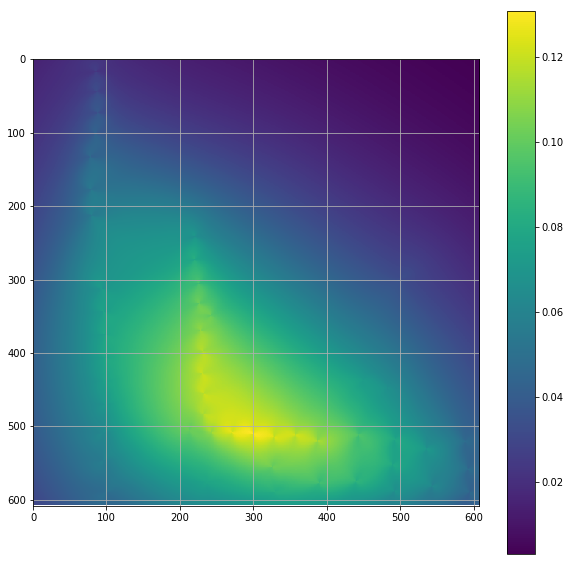

In [19]:
road_metric_plot = road_metric

print(road_metric_plot)
print(np.max(road_metric_plot))
print(np.min(road_metric_plot))

road_metric_plot_2d = road_metric_plot.reshape(img.shape[0],img.shape[1])

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
im = ax1.imshow(road_metric_plot_2d)
#ax1.legend(scatterpoints=1)
ax1.invert_yaxis()
ax1.set_ylim(bottom=608,top=0)
ax1.set_xlim(left=0,right=608)
ax1.grid()

cbar = fig.colorbar(im,ax=ax1)
plt.show()

In [20]:
#Optional scaling factor to set relative importance of HSV vs XY for KMeans inference

feats_pred_final = feats_pred_scaled.copy()

xy_weight = 1.0
feats_pred_final[:,:2] = feats_pred_scaled[:,:2]*xy_weight
print(feats_pred_scaled[0])

hsv_weight = 1.0
#hsv_scale_factor = 0.1
feats_pred_final[:,2:5] = feats_pred_scaled[:,2:5]*hsv_weight

rm_weight = 0.0
rm_factor = np.std(road_metric)
print(np.std(road_metric))
feats_pred_final[:,5] = np.exp( (np.max(road_metric)-road_metric)/rm_factor )
feats_pred_final[:,5] = feats_pred_scaled[:,5]*rm_weight






[-1.54774365 -2.69227121 -1.10678784  1.18048723 -1.97630091  0.        ]
0.030799819567155


In [21]:
#Calculate kmeans prediction scores for each pixel
#Score related to distance to nearest centroid
#Large negative score means bad

#Slow to run, consider calculating in patches

scores = np.zeros((img.shape[0],img.shape[1]))
patch_h = 4
patch_w = 4
for yp in range(int(img.shape[0]/patch_h)):
    for xp in range(int(img.shape[1]/patch_w)):
        #patch_feats = []
        patch_feats_sum = np.zeros(feats_pred_scaled.shape[1])
        for py in range(patch_h):
            start_idx = img.shape[0]*(py+yp*patch_h)+xp*patch_w
            end_idx = start_idx+patch_w
            #patch_feats.append(feats_pred_scaled[start_idx:end_idx])
            patch_feats_sum += np.sum(feats_pred_scaled[start_idx:end_idx],axis=0)
        #patch_feats = tuple(patch_feats)
        #patch_feats = np.concatenate(patch_feats)
        #patch_feats_avg = np.expand_dims(np.mean(patch_feats,axis=0),axis=0)
        patch_feats_avg = patch_feats_sum/patch_h/patch_w
        patch_score_est = km.score( np.expand_dims(patch_feats_avg,axis=0) )/patch_h/patch_w
        for py in range(patch_h):
            scores[py+yp*patch_h][xp*patch_w:(xp+1)*patch_w] = patch_score_est


#log_neg_scores = np.log10(-1.0*scores )
#plt.hist(log_neg_scores,bins=100)


In [28]:
print("done")
print(np.mean(scores))
print(np.mean(np.log10(-1.0*scores)))
print(np.max(scores))

done
-1.0193171871563753
-0.355651138134448
-0.0022420967636948433


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

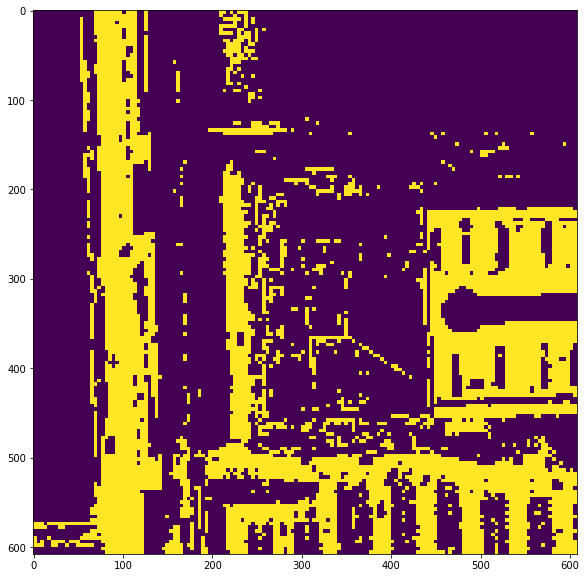

In [22]:
GOODSCORE_THRESHOLD = -0.1

binary_map_goodscore = (scores > GOODSCORE_THRESHOLD).astype('uint8')
binary_map_goodscore = binary_map_goodscore.reshape((608,608))

print(binary_map_goodscore[0])

plt.figure(figsize=(10, 10))
plt.imshow(binary_map_goodscore)



In [ ]:
from scipy import ndimage

b = binary_map_goodscore.copy()

plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_dilation(b).astype(b.dtype)
plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_dilation(b).astype(b.dtype)
plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_dilation(b).astype(b.dtype)
plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:

b = ndimage.binary_erosion(b).astype(b.dtype)

plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_erosion(b).astype(b.dtype)

plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_erosion(b).astype(b.dtype)

plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
b = ndimage.binary_erosion(b).astype(b.dtype)

plt.figure(figsize=(10, 10))
plt.imshow(b)

In [ ]:
scaler_pred_hsv = StandardScaler()
scaler_pred_hsv.fit(feats_pred_hsv)
print(scaler_pred_hsv.mean_[0])
print(np.sqrt(scaler_pred_hsv.var_[0]))

feats_pred_hsv_normed = scaler_pred_hsv.transform(feats_pred_hsv)